# Chapter 4: Bayesian Statistics (Working in progress proof of concept)

In [1]:
# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../")

# Importing gempy
import gempy as gp

# Embedding matplotlib figures into the notebooks
%matplotlib inline

# Aux imports
import numpy as np

import matplotlib.pyplot as plt

In [40]:

# Importing the data from csv files and settign extent and resolution
geo_data = gp.create_data([-1000,3000,-1000,3000,-2000,0],[ 8,8,8],
                         path_f = os.pardir+"/input_data/FabLessPoints_Foliations.csv",
                         path_i = os.pardir+"/input_data/FabLessPoints_Points.csv")

In [1]:
# Assigning series to formations as well as their order (timewise)
gp.set_data_series(geo_data, {"fault":geo_data.formations[4], 
                      "Rest":np.delete(geo_data.formations, 4)},
                       order_series = ["fault",
                                       "Rest",
                                       ], verbose=0)

NameError: name 'gp' is not defined

In [42]:
geo_data.interfaces['X_std'] = None
geo_data.interfaces['Y_std'] = 0
geo_data.interfaces['Z_std'] = 20


geo_data.foliations['X_std'] = None
geo_data.foliations['Y_std'] = 0
geo_data.foliations['Z_std'] = 0

geo_data.foliations['dip_std'] = 10
geo_data.foliations['azimuth_std'] = 10

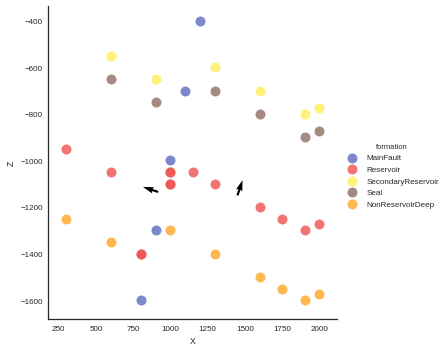

In [43]:
gp.plot_data(geo_data)

In [44]:
interp_data = gp.InterpolatorInput(geo_data, compile_theano=True, u_grade=[0,0])

I am here
I am in the setting
float32
I am here
[2, 2]


In [45]:
interp_data.data.interfaces['Z'].min(), interp_data.data.interfaces['Z'].max()

(0.34625384615384613, 0.6539461538461538)

In [46]:
sol_default = gp.compute_model(interp_data)

[0, 0]


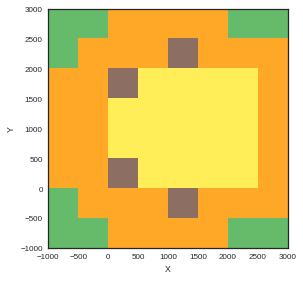

In [47]:
gp.plot_section(geo_data, sol_default[0,:], -1, direction='z')

In [48]:
def precompute_grav(interp_data):
    """
    model_res: number of voxels
    interp_data: interp_data object with the specific resolution
    """
    
    import sys
    import gempy as gp
    sys.path.append("../gempy")
    import GeoPhysics
    import theano.tensor as T
    import theano
    from importlib import reload
    reload(GeoPhysics)

    #inter_data = gp.InterpolatorInput(geo_data, compile_theano=False)
    gpp = GeoPhysics.GeoPhysicsPreprocessing(interp_data,580,  [800,1200,800,1200,-1900,0], 
                                  res_grav = [5, 5],
                                  n_cells = 10, mode='range')
                                  #res_grav = [125, 85],
                                  #n_cells =1000)
    print(gpp)

    
    # Compile Theano function
    x_1 = T.matrix()
    x_2 = T.matrix()

    sqd = T.sqrt(T.maximum(
        (x_1 ** 2).sum(1).reshape((x_1.shape[0], 1)) +
        (x_2 ** 2).sum(1).reshape((1, x_2.shape[0])) -
        2 * x_1.dot(x_2.T), 0
    ))
    eu = theano.function([x_1, x_2], sqd, allow_input_downcast=True)
        
    # Init
    i_0 = 0
    model_res = interp_data.resolution[0] * interp_data.resolution[1] * interp_data.resolution[2]
    b_all = np.zeros((0,model_res), dtype=bool)
    
    # 25 is the size of the chunk
    for i_1 in np.arange(25, gpp.airborne_plane.shape[0]+1, 25, dtype=int):#np.linspace(gpp.airborne_plane.shape[0]/25, gpp.airborne_plane.shape[0], 26, dtype=int):
        airborne_plane_s = gpp.airborne_plane[i_0:i_1]

        # Here we set the gravity points over the original model resolution
        d = eu(interp_data.data.grid.grid.astype('float'), airborne_plane_s)
        ab_g = interp_data.data.grid.grid[np.argmin(d, axis=0)]
        ab_g[:,2] = ab_g[:,2] + 0.01
        
        # And now we compute the measurement points to 
        d2 = eu(ab_g, interp_data.data.grid.grid.astype('float'))
        
        # Max range to select voxels
        range_ = (interp_data.data.grid.grid[:, 2].max() - interp_data.data.grid.grid[:, 2].min()) *0.9
        
        # Boolean of the selection
        b = d2<range_
        
        # Beoolean for all measurements
        b_all = np.vstack((b_all, b))
        
        # Selection of the x y z coordenates for each measurement and computed distance in those coordinates
        s_gr_x = (np.repeat(interp_data.data.grid.grid, 25, axis=1)[:, :25].T[b].reshape(25,-1) - ab_g[:,0].reshape(25,-1)).astype('float')
        s_gr_y = (np.repeat(interp_data.data.grid.grid, 25, axis=1)[:, 25:50].T[b].reshape(25,-1) - ab_g[:,1].reshape(25,-1)).astype('float')
        s_gr_z = (np.repeat(interp_data.data.grid.grid, 25, axis=1)[:, -25:].T[b].reshape(25,-1) - ab_g[:,2].reshape(25,-1)).astype('float')
        
        # getting the coordinates of the corners of the voxel
        x_cor = np.stack((s_gr_x - gpp.vox_size[0], s_gr_x + gpp.vox_size[0]), axis=2)
        y_cor = np.stack((s_gr_y - gpp.vox_size[1], s_gr_y + gpp.vox_size[1]), axis=2)
        z_cor = np.stack((s_gr_z - gpp.vox_size[2], s_gr_z + gpp.vox_size[2]), axis=2)

        # ...and prepare them for a vectorial op
        x_matrix = np.repeat(x_cor, 4, axis=2)
        y_matrix = np.tile(np.repeat(y_cor, 2, axis=2), (1, 1, 2))
        z_matrix = np.tile(z_cor, (1, 1, 4))
        
        # Distances to each corner of the voxel
        s_r = np.sqrt(x_matrix**2 + y_matrix**2 + z_matrix**2)


        # Computing z component
        from scipy.constants import G
        mu = np.array([1, -1, -1, 1, -1, 1, 1, -1])

        tz = np.sum(- G * mu * (
                x_matrix * np.log(y_matrix + s_r) +
                y_matrix * np.log(x_matrix + s_r) -
                z_matrix * np.arctan(x_matrix * y_matrix /
                                    (z_matrix * s_r))), axis=2)

        # Stacking the precomputation
        if i_0 == 0:
            tz_all = tz

        else:
            tz_all = np.vstack((tz_all, tz))

        i_0 = i_1
    return tz_all, b_all

In [49]:
tz_, b_ = precompute_grav(interp_data)

0.4615384615384615


In [50]:
import pymc

Z_rest = pymc.Normal('Z_unc_rest',  interp_data.interpolator.pandas_rest_layer_points['Z'].values.astype('float32'),
           1./interp_data.interpolator.pandas_rest_layer_points['Z_std'].values.astype('float32'))

Z_ref = pymc.Normal('Z_unc_ref',  interp_data.interpolator.pandas_ref_layer_points['Z'].values.astype('float32'),
           1./interp_data.interpolator.pandas_ref_layer_points['Z_std'].values.astype('float32'))

dip_u = pymc.Normal('dip_unc',  interp_data.data.foliations['dip'].values.astype('float32'),
           1./interp_data.data.foliations['dip_std'].values.astype('float32'))

azimuth_u = pymc.Normal('azimuth_unc',  interp_data.data.foliations['azimuth'].values.astype('float32'),
           1./interp_data.data.foliations['azimuth_std'].values.astype('float32'))

i = interp_data.get_input_data()

@pymc.deterministic
def grav(value=0, input_ =  i, Z_rest_m = Z_rest, Z_ref_m = Z_ref, dip_m = dip_u, azimuth_m = azimuth_u):

   # print(Z_rest_m)
    
    input_[1] = dip_m.astype('float32')
    input_[2] = azimuth_m.astype('float32')
    input_[4][:, 2] = Z_ref_m
    input_[5][:, 2] = Z_rest_m
    try:
        sol = interp_data.th_fn(*input_)
        lith = sol[-1, 0,:]
    except:
        lith = sol_default[0, :]
    # return solution
 
    
    np.place(lith, lith == 5, 3)
    np.place(lith, lith == 2, 2.92)
    np.place(lith, lith == 3, 3.1)
    np.place(lith, lith == 4, 2.92)
    np.place(lith, lith == 0, 2.61)
    
   # print(lith.shape, lith)
    lith_s = np.tile(lith, (25,1))[b_].reshape(25,-1)
    grav = lith_s* tz_
    return grav.sum(axis=1)
    
  #  return sol

# @pymc.deterministic
# def grav(value=0, model=gempy_model):
#     lith = model[-1, 0, :]
#     lith_s = np.tile(lith, (25,1))[b_].reshape(25,-1)
#     grav = lith_s* tz_
#     return grav.sum(axis=1)

[0, 0]


In [51]:

np.random.seed(123456)
pymc_model = pymc.Model(input = [Z_ref, Z_rest,  dip_u,  azimuth_u, grav])

MCFS_fault_8 = pymc.MCMC(pymc_model,  db='pickle', dbname='MCMC_f_8.pickle')
MCFS_fault_8.sample(iter=100)

 [-----            13%                  ] 1398 of 10000 complete in 3.5 sec

/home/miguel/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.0108361076818255e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


 [------           17%                  ] 1797 of 10000 complete in 4.5 sec

/home/miguel/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.5971511042353086e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


 [-------          19%                  ] 1978 of 10000 complete in 5.0 sec

/home/miguel/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.581836706066042e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


 [---------        25%                  ] 2574 of 10000 complete in 6.5 sec

/home/miguel/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.3664874504447653e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


 [-----------      29%                  ] 2974 of 10000 complete in 7.5 sec

/home/miguel/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.641165401470971e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


 [-------------    35%                  ] 3559 of 10000 complete in 9.0 sec

/home/miguel/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.3794484604877653e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


 [--------------   37%                  ] 3754 of 10000 complete in 9.5 sec

/home/miguel/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.3723270459186097e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


 [-----------------47%                  ] 4753 of 10000 complete in 12.0 sec

/home/miguel/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.946047127418751e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


 [-----------------53%                  ] 5351 of 10000 complete in 13.5 sec

/home/miguel/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.1831234658643552e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


 [-----------------83%-----------       ] 8340 of 10000 complete in 21.0 sec

/home/miguel/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.7330790781406904e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


 [-----------------89%-------------     ] 8942 of 10000 complete in 22.6 sec

/home/miguel/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.548300580609066e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


 [-----------------100%-----------------] 10000 of 10000 complete in 25.2 sec

/home/miguel/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.840697360146805e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


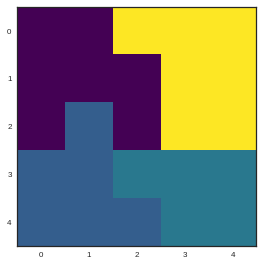

In [52]:
plt.imshow(MCFS_fault_16.trace('grav')[5, :].reshape(5,5), cmap='viridis')

In [53]:

np.nonzero(MCFS_fault_16.trace('grav')[:, 5])

(array([   0,    1,    2, ..., 9997, 9998, 9999]),)

In [54]:
MCFS_fault_16.trace('grav')[:, 5]

array([  1.67986398e-09,   1.61314110e-09,   1.68524938e-09, ...,
         1.69248206e-09,   1.66085595e-09,   1.62828483e-09])